In [85]:
import psycopg2
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

warnings.filterwarnings("ignore", message="pandas only supports SQLAlchemy connectable.*")

conn = psycopg2.connect(
    dbname="desafio",
    user="desafio",
    password="desafio",
    host="localhost",
    port="5432"
)

In [2]:
query = "SELECT * FROM routes"
df_routes = pd.read_sql(query, conn)
df_routes.head()

,route_id,origin,destination,total_distance,arrival_time
0,1,São Paulo,Belo Horizonte,585.086,2024-06-10 08:47:29
1,2,São Paulo,Rio de Janeiro,446.262,2024-06-10 06:50:38
2,3,São Paulo,Vitória,947.906,2024-06-10 13:51:20
3,4,Belo Horizonte,São Paulo,583.905,2024-06-10 08:46:03
4,5,Belo Horizonte,Rio de Janeiro,441.244,2024-06-10 07:20:49


In [3]:
query = "SELECT * FROM routesteps"
df_steps = pd.read_sql(query, conn)
df_steps.head()

,step_id,route_id,step_order,coordinates,distance,estimated_arrival_time
0,1,1,1,"(-23.5557715,-46.6395569)",0.392,2024-06-10 01:14:03
1,2,1,2,"(-23.5526298,-46.6378143)",0.265,2024-06-10 01:15:06
2,3,1,3,"(-23.5518717,-46.635425)",0.084,2024-06-10 01:15:27
3,4,1,4,"(-23.5511615,-46.63549099999999)",0.434,2024-06-10 01:16:52
4,5,1,5,"(-23.5489017,-46.6387136)",0.106,2024-06-10 01:17:04


In [4]:
query = "SELECT * FROM weatherconditions"
df_weather = pd.read_sql(query, conn)
df_weather.head()

,weather_id,step_id,weather_time,weather_description,temperature
0,1,1,2024-06-10 03:00:00,scattered clouds,18.60
1,2,2,2024-06-10 03:00:00,scattered clouds,18.57
2,3,3,2024-06-10 03:00:00,scattered clouds,18.57
3,4,4,2024-06-10 03:00:00,scattered clouds,18.57
4,5,5,2024-06-10 03:00:00,scattered clouds,18.57


In [61]:
df = pd.merge(df_routes, df_steps, on='route_id')
df = pd.merge(df, df_weather, on='step_id')

df['arrival_time'] = pd.to_datetime(df['arrival_time'])
df['weather_time'] = pd.to_datetime(df['weather_time'])

df['step_duration'] = df['estimated_arrival_time'] - df['estimated_arrival_time'].shift(1)
df['step_duration'] = df['step_duration'].dt.total_seconds() / 60

step_one_times = df[df['step_order'] == 1][['route_id', 'estimated_arrival_time']]

step_one_times = step_one_times.rename(columns={'estimated_arrival_time': 'start_time'})

df = pd.merge(df, step_one_times, on='route_id', how='left')

df_grouped = df.groupby(['route_id','origin', 'destination','start_time'])['weather_description']\
                .agg(lambda x: pd.Series.mode(x)[0]).reset_index(name='most_common_weather')\
                .sort_values(by=['origin', 'destination'])

C:\Users\isaab\AppData\Local\Temp\ipykernel_1068\731007480.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for route, group in df_grouped.groupby(['origin_destination']):


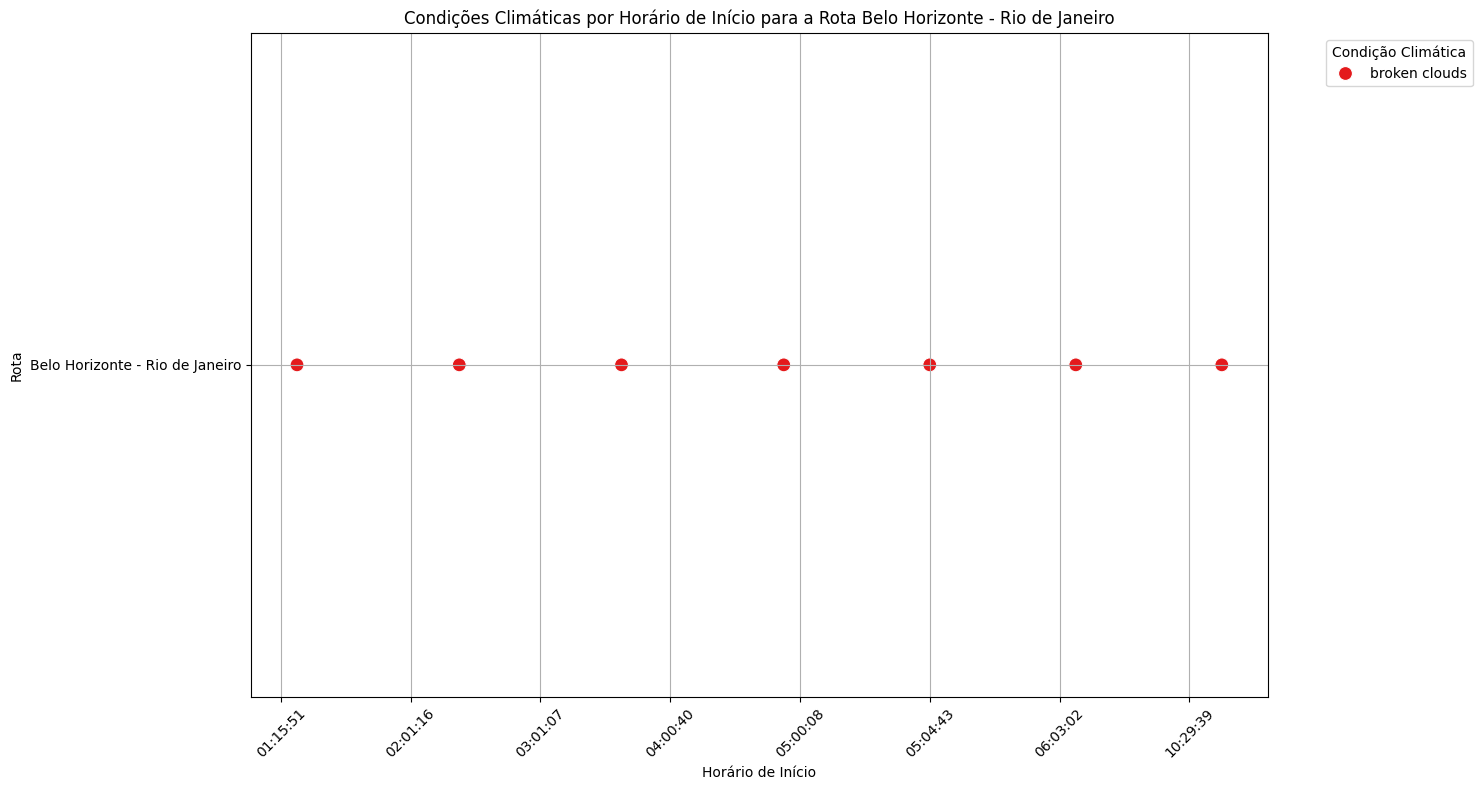

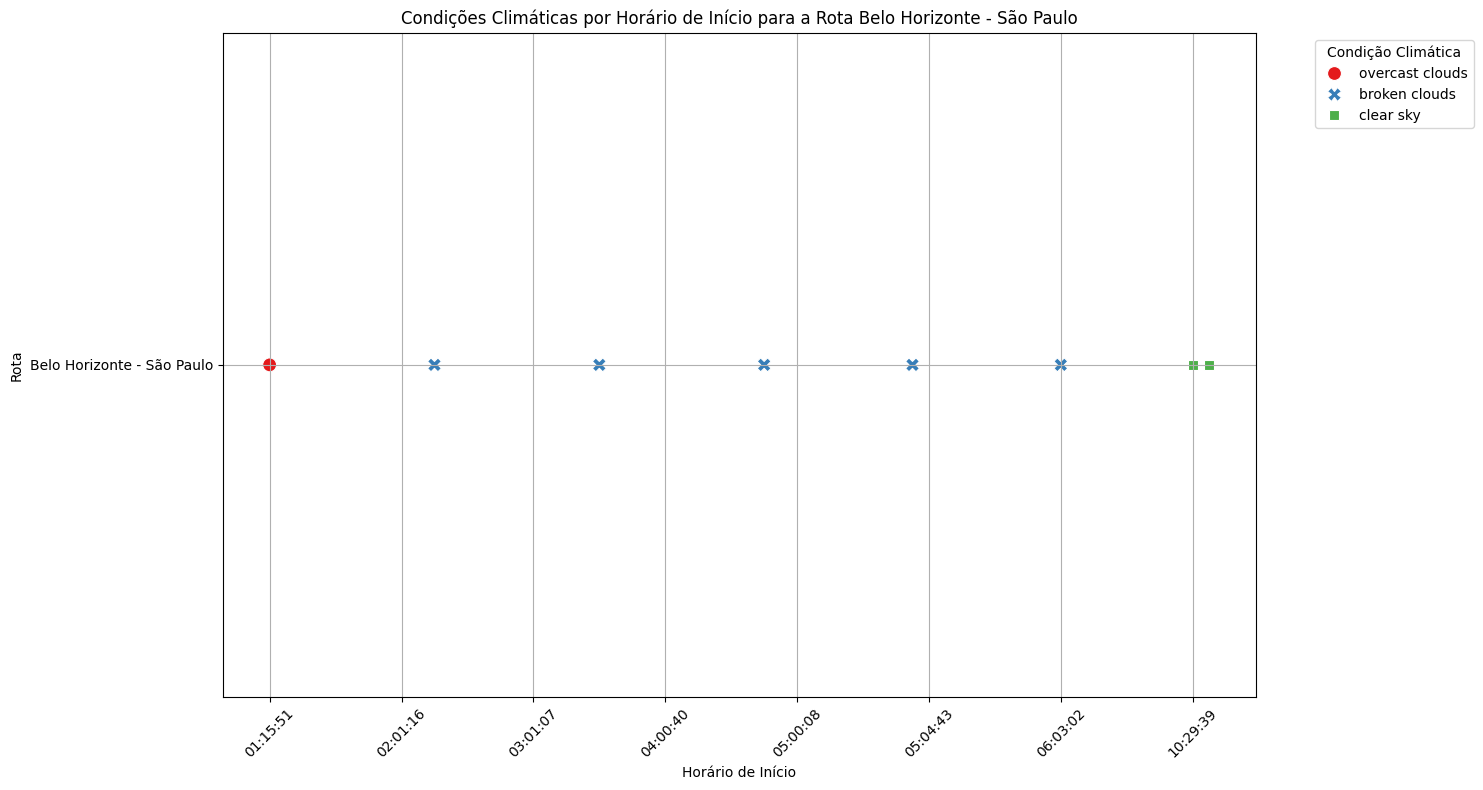

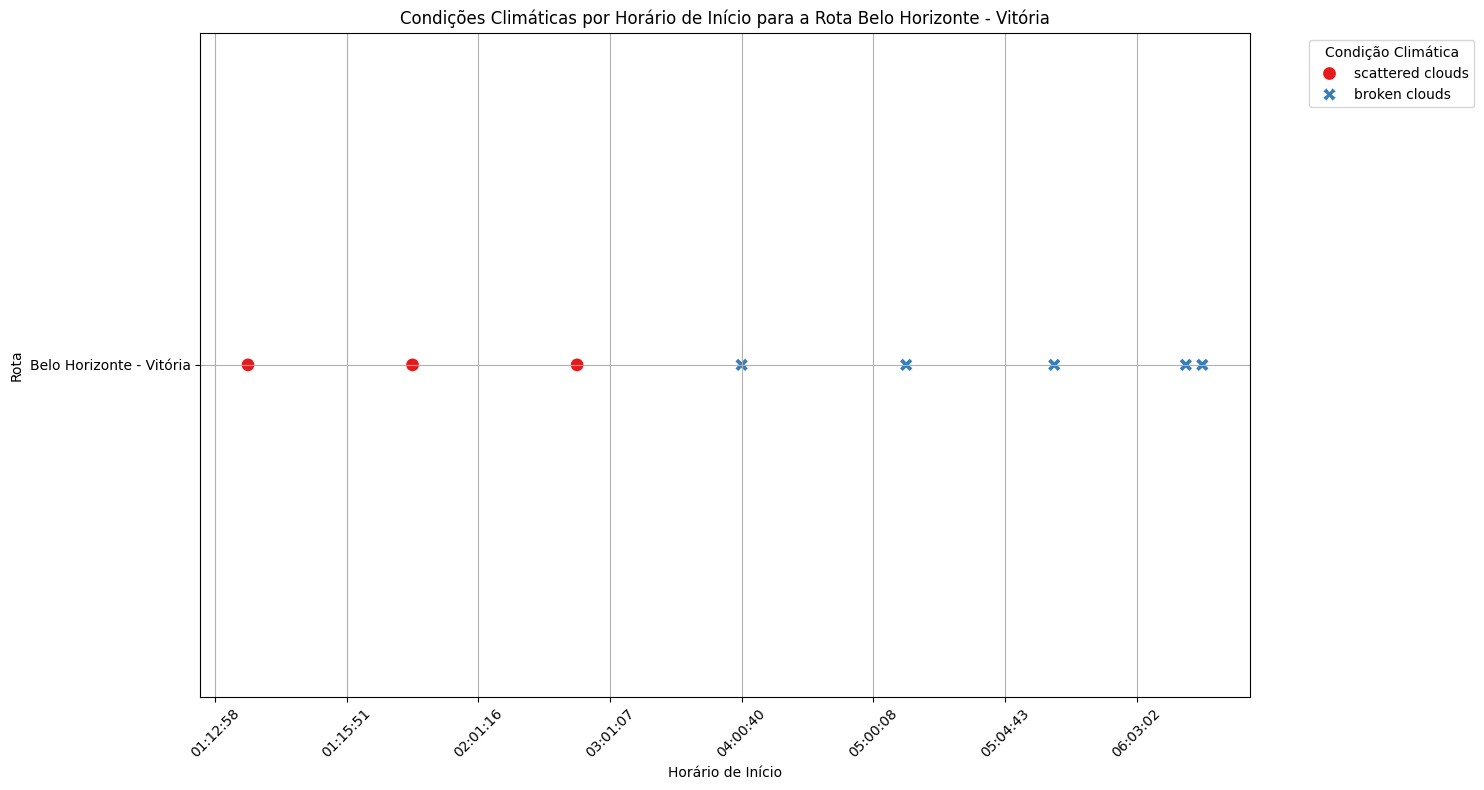

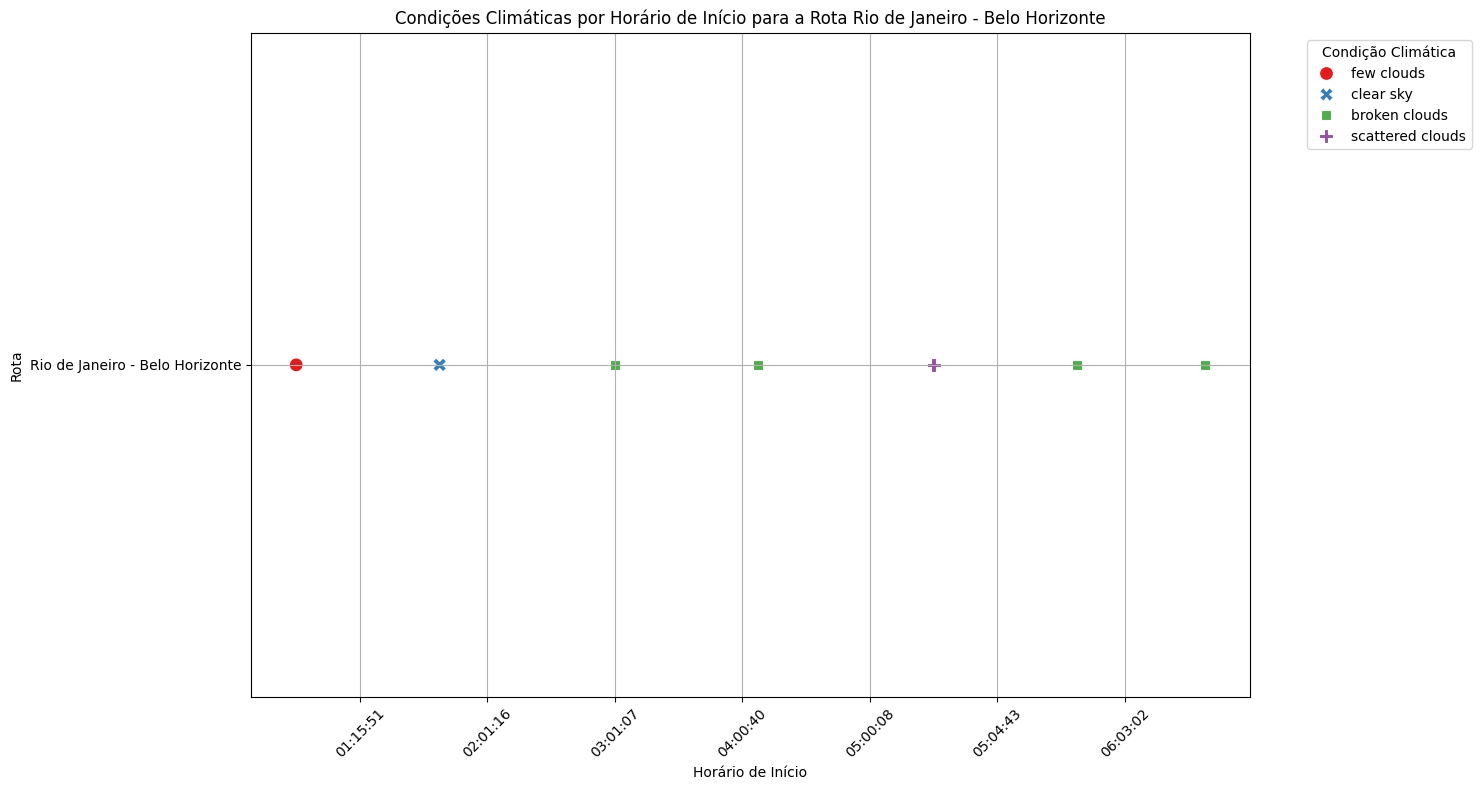

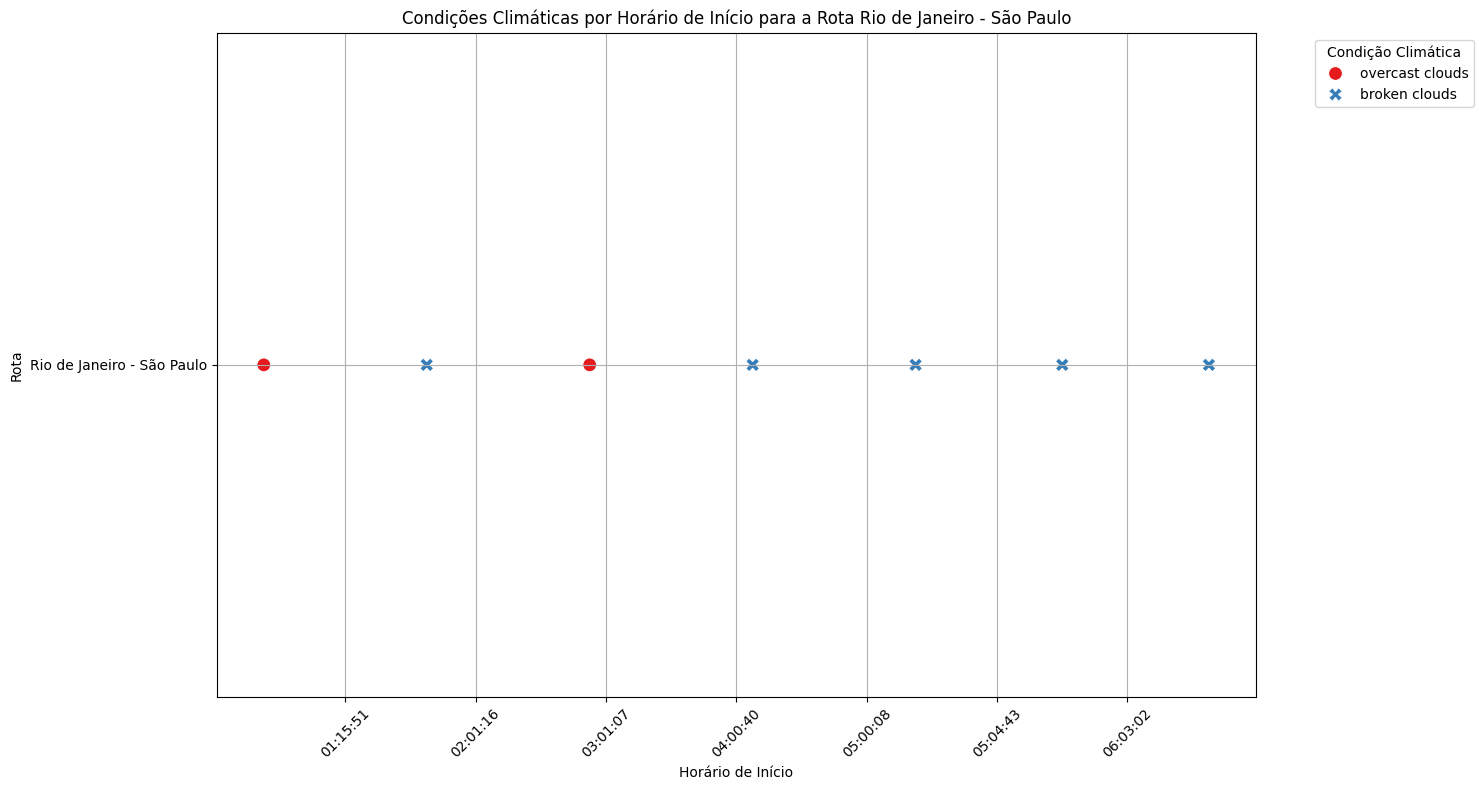

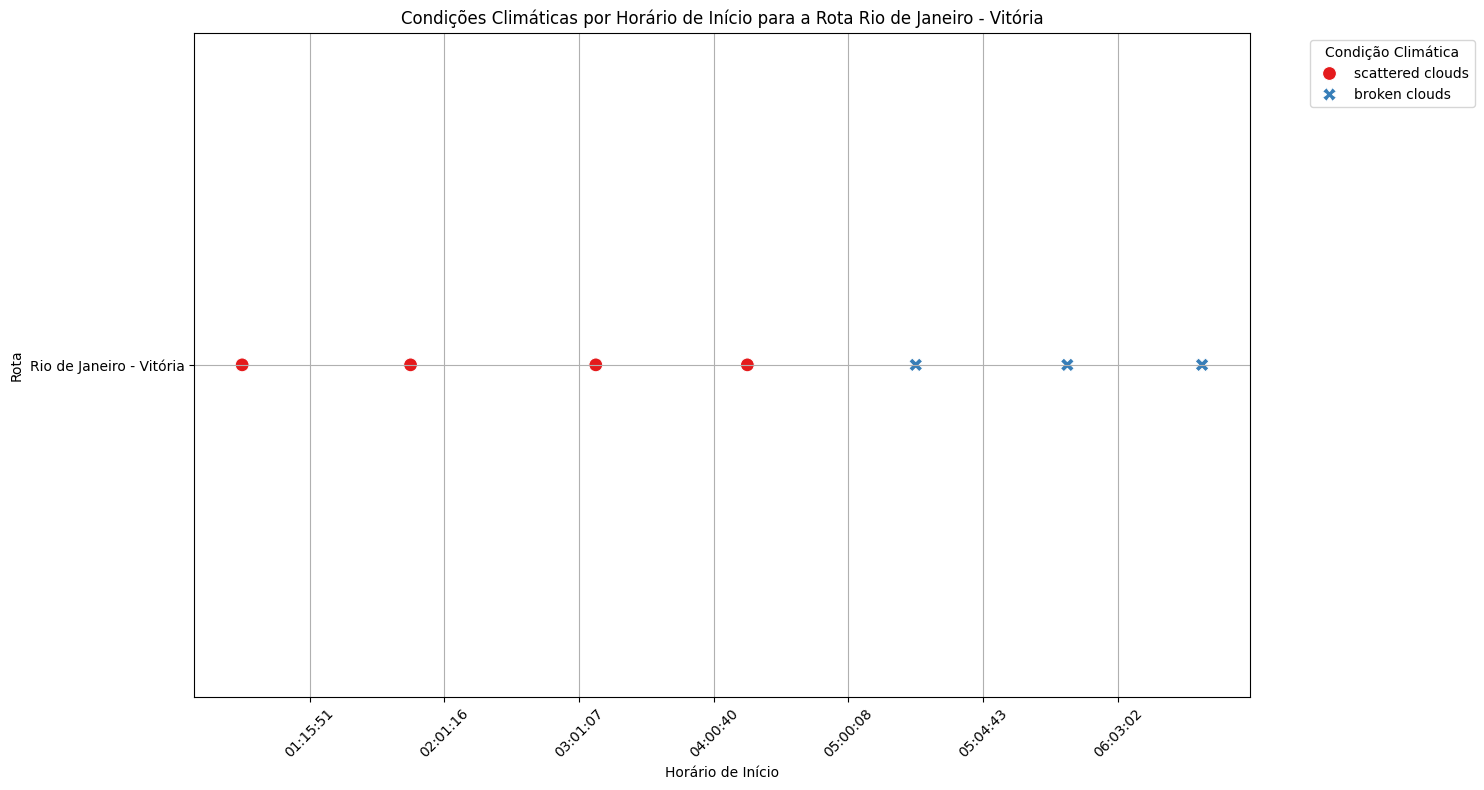

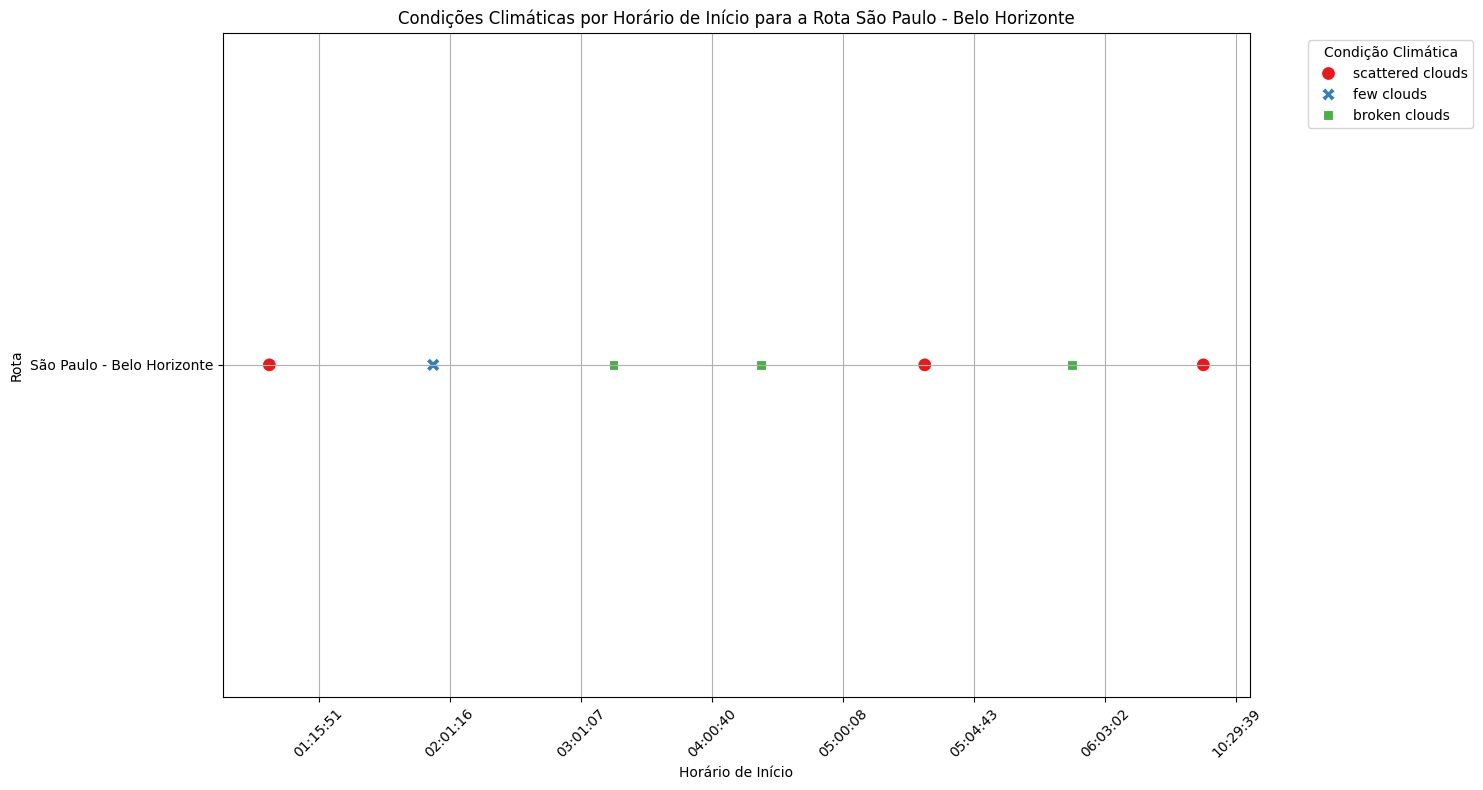

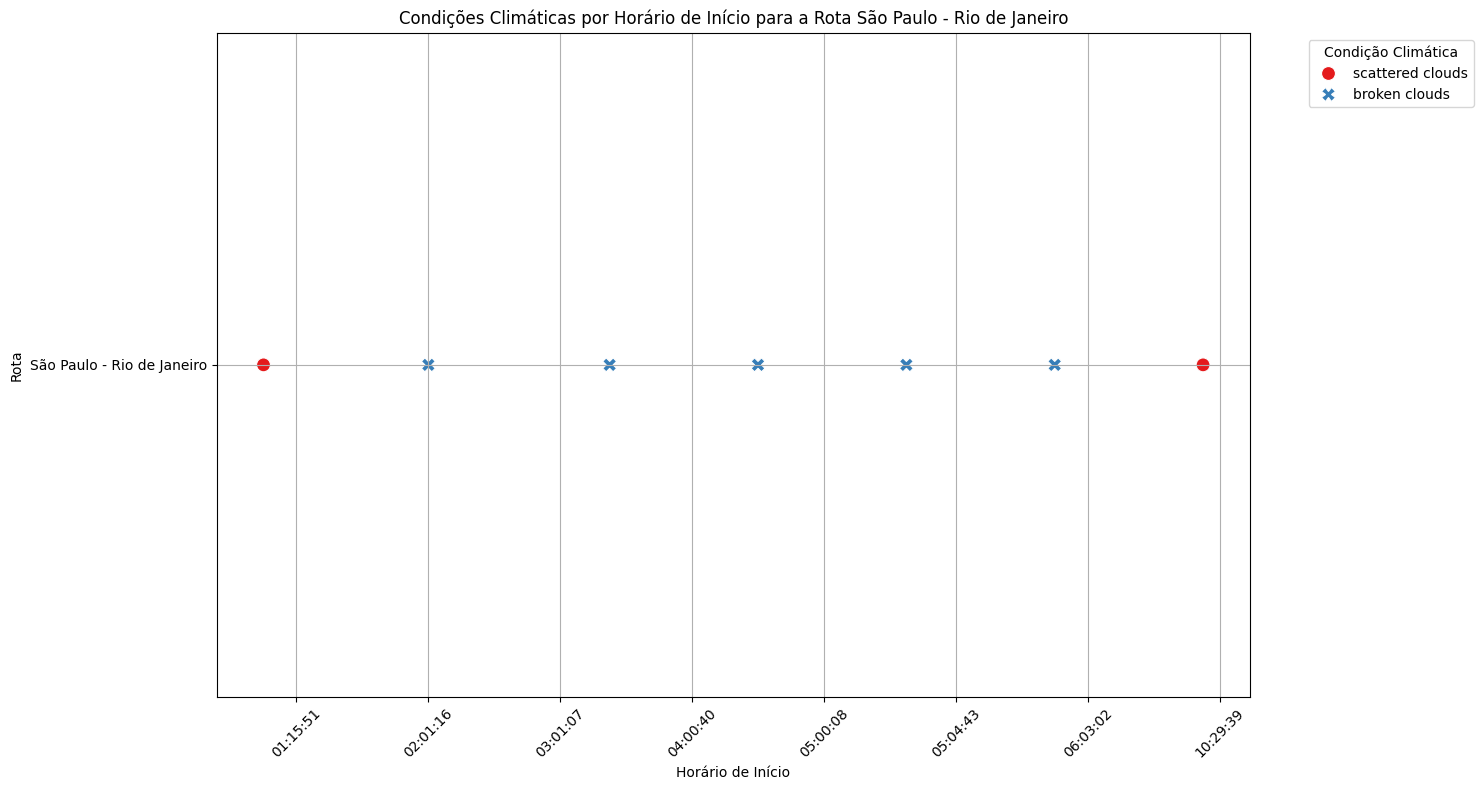

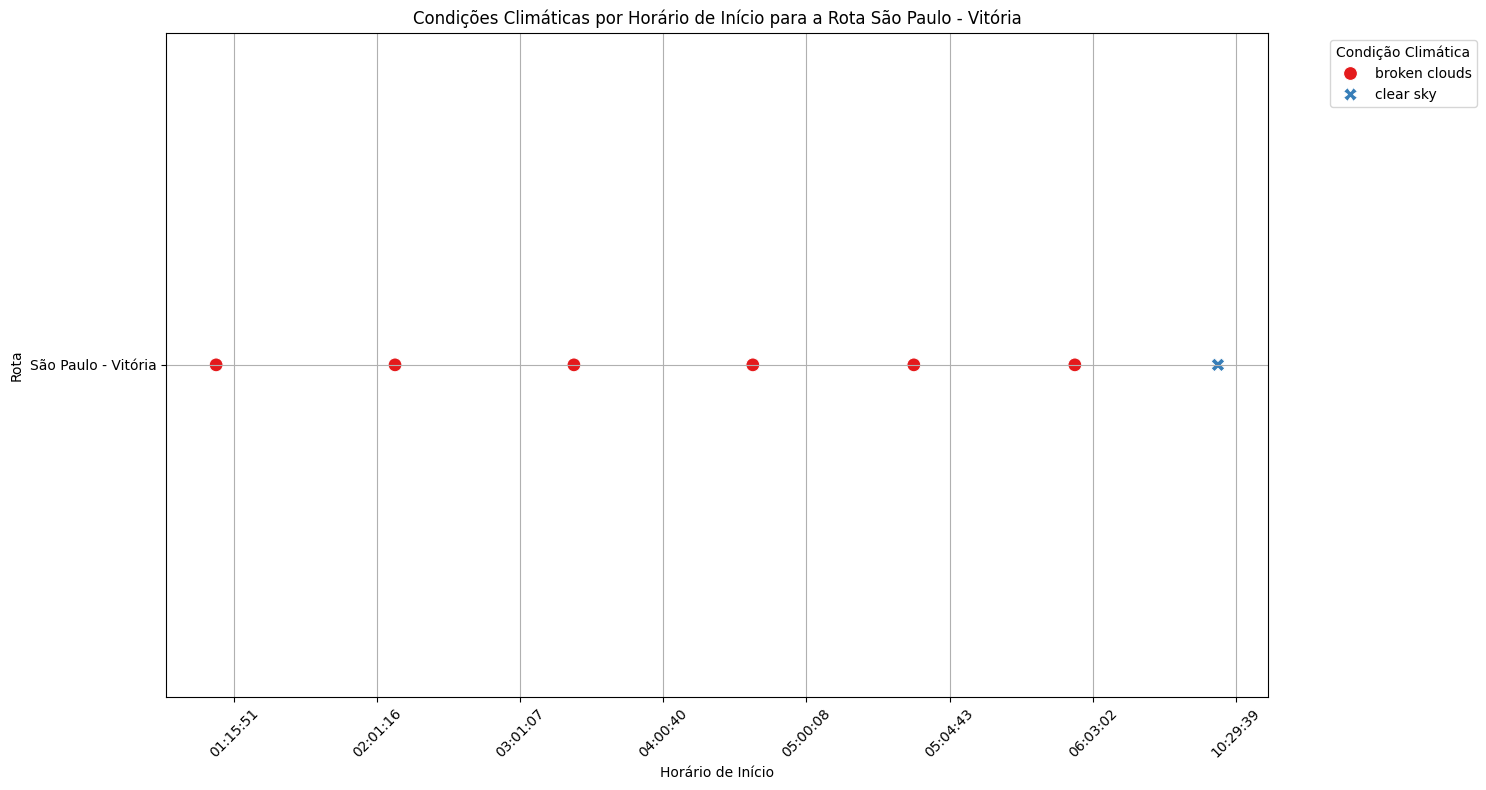

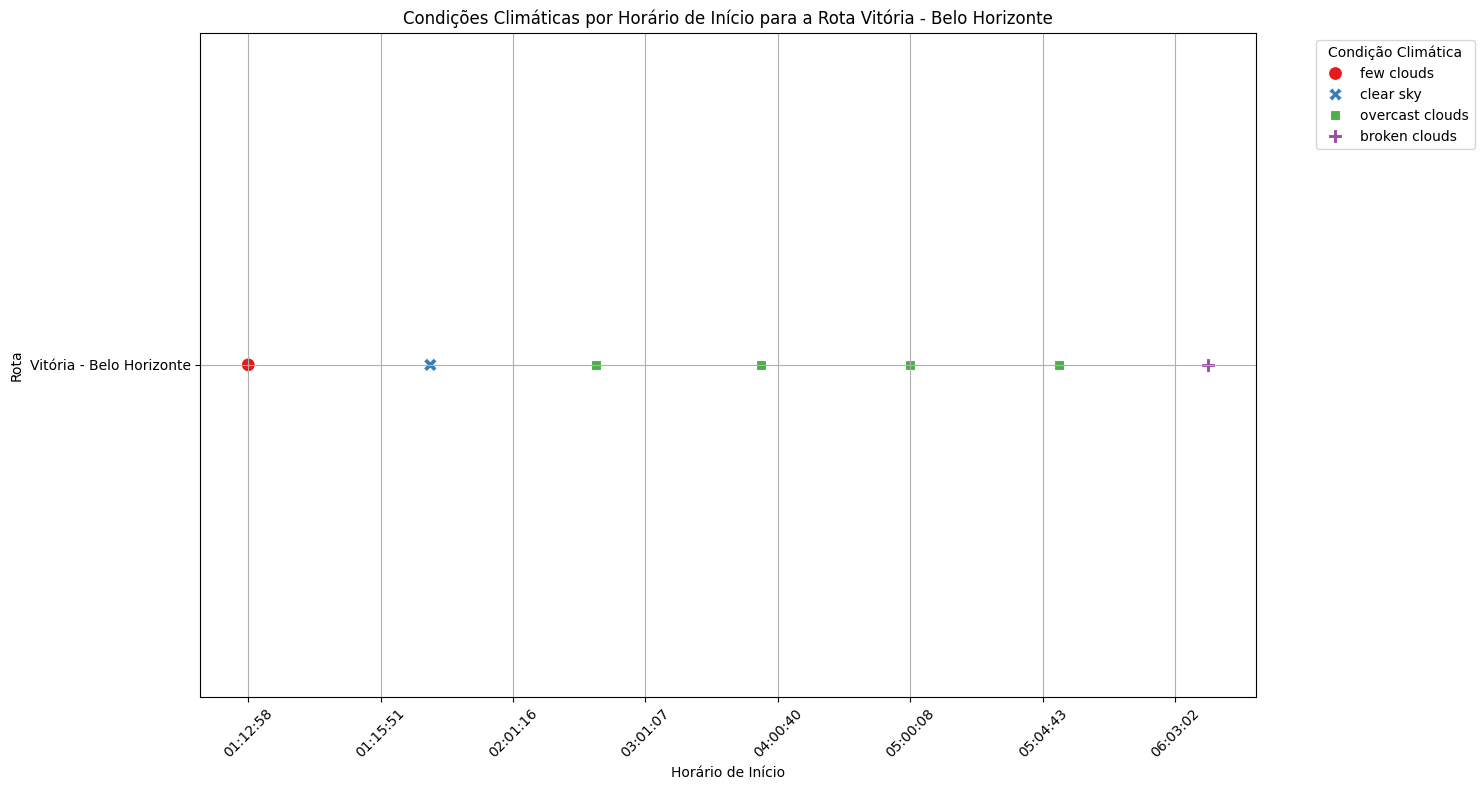

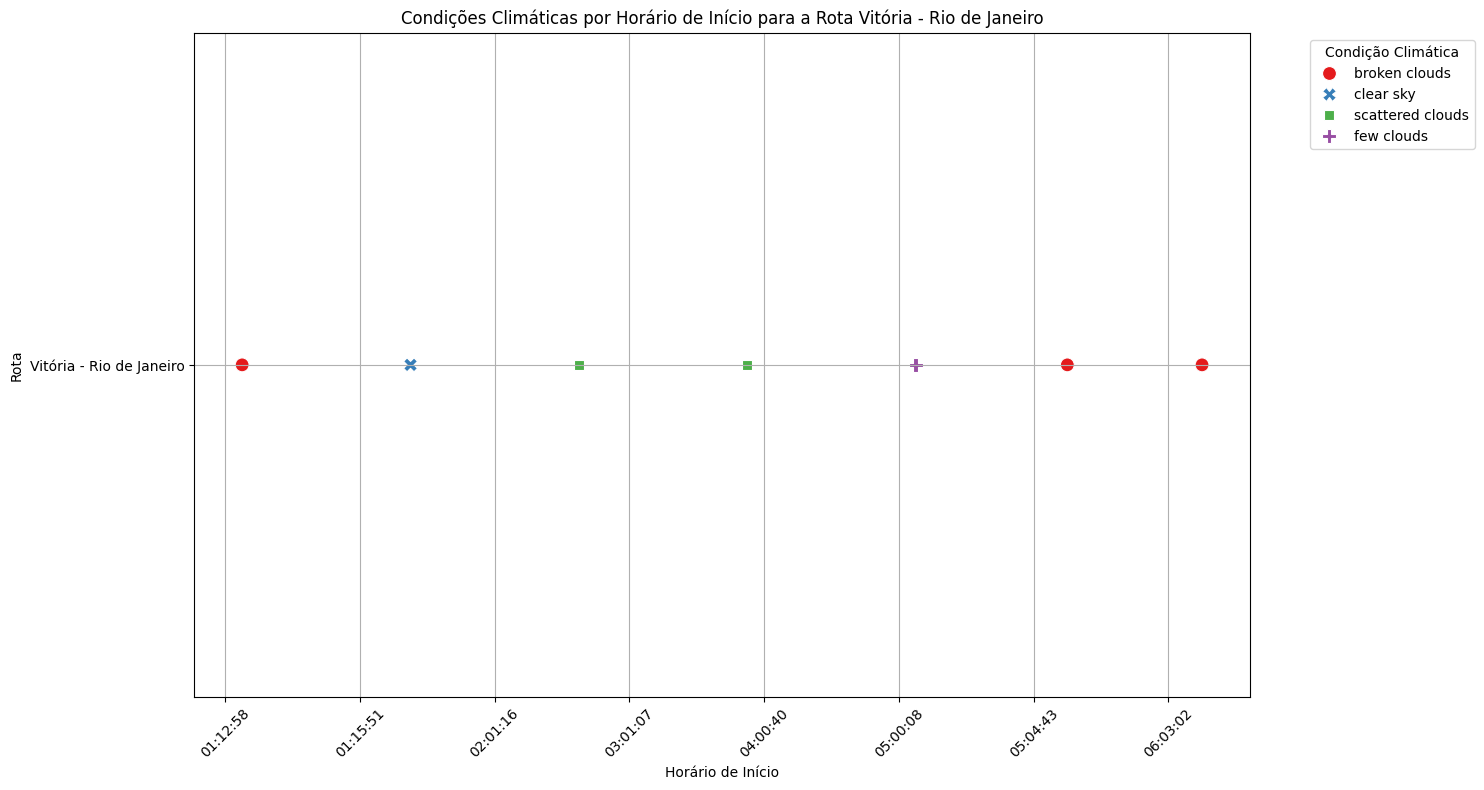

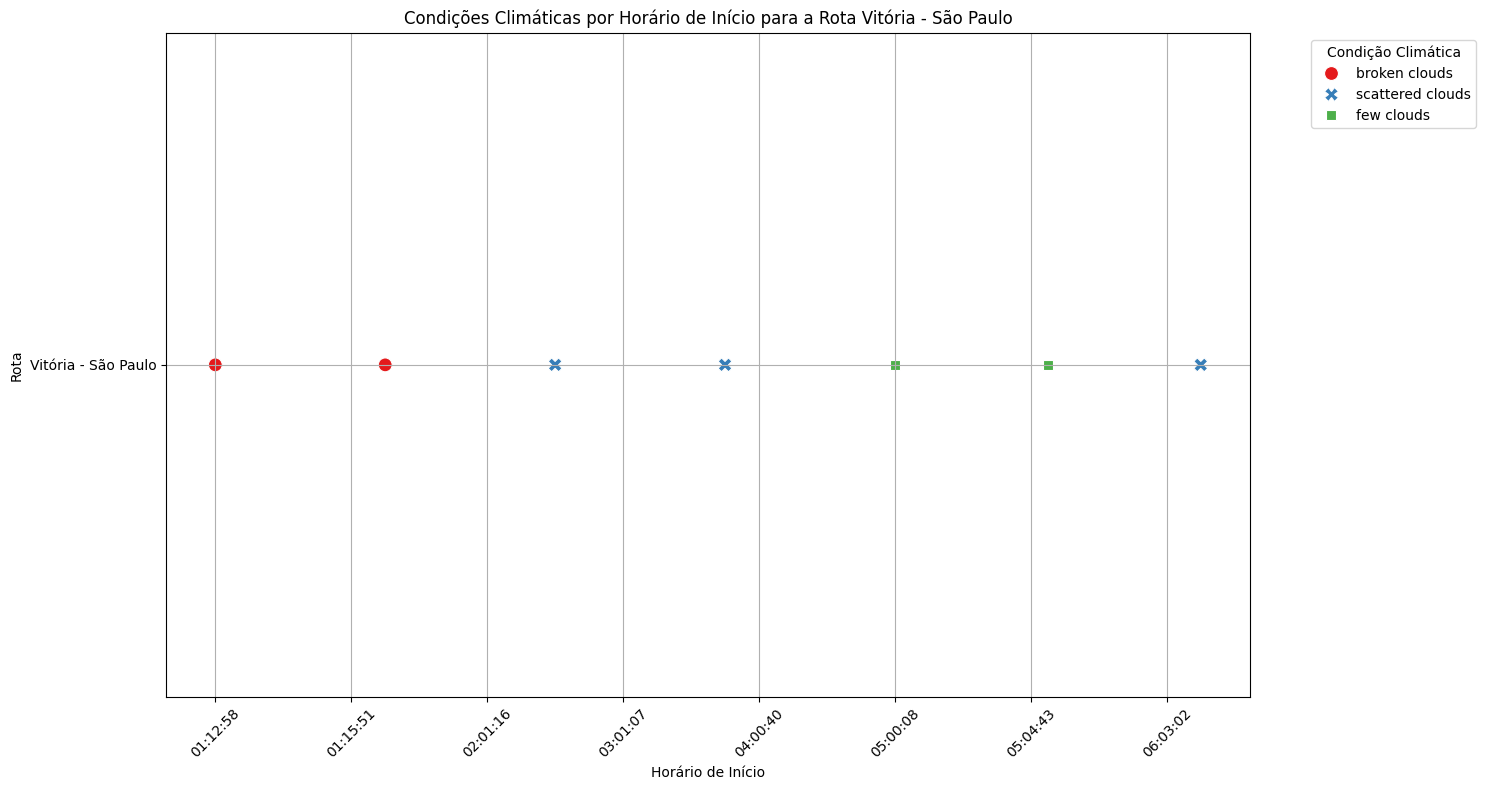

In [86]:
df_grouped['time_only'] = pd.Categorical(df_grouped['time_only'], categories=sorted(df_grouped['time_only'].unique()), ordered=True)
df_grouped['origin_destination'] = df_grouped['origin'] + ' - ' + df_grouped['destination']

for route, group in df_grouped.groupby(['origin_destination']):
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    sns.scatterplot(x='time_only', y='origin_destination', hue='most_common_weather', style='most_common_weather', data=group, s=100, palette='Set1')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
    plt.title(f'Condições Climáticas por Horário de Início para a Rota {route}')
    plt.xlabel('Horário de Início')
    plt.ylabel('Rota')
    plt.xticks(rotation=45)
    plt.legend(title='Condição Climática', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

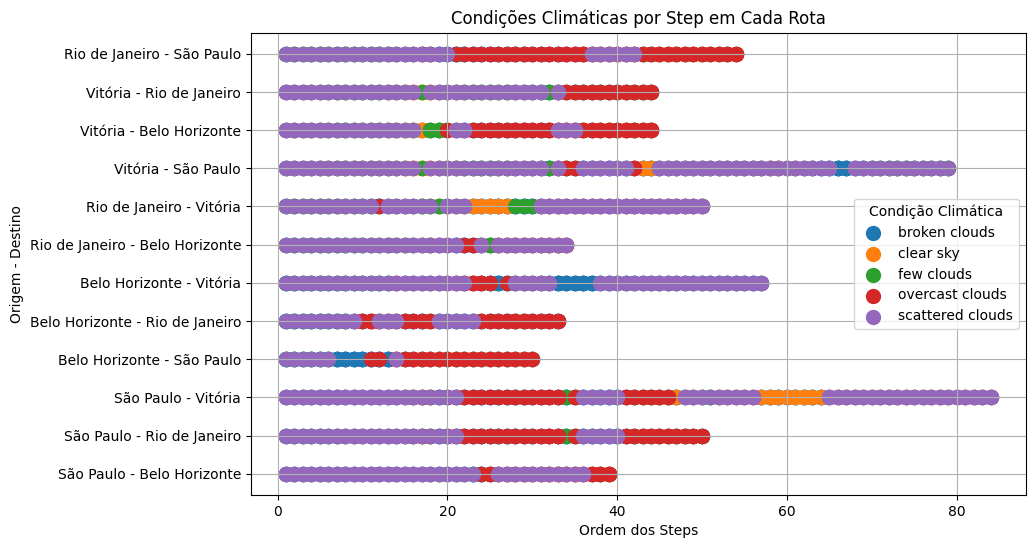

In [80]:
df['origin_destination'] = df['origin'] + ' - ' + df['destination']

plt.figure(figsize=(10, 6))
for label, grp in df.groupby('weather_description'):
    plt.scatter(grp['step_order'], grp['origin_destination'], label=label, s=100)

plt.xlabel('Ordem dos Steps')
plt.ylabel('Origem - Destino')
plt.title('Condições Climáticas por Step em Cada Rota')
plt.legend(title='Condição Climática')
plt.grid(True)
plt.show()